<a href="https://colab.research.google.com/github/AbhishekSinghKushwah7/Plant-Disease-Identification-via-Deep-Learning/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 2**

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/new_drive')

Mounted at /content/new_drive


In [3]:
train_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL/train"
val_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL/val"
test_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL/test"

classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [4]:
def preprocess_function(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

In [35]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             preprocessing_function=preprocess_function)

IMAGE_SIZE = (224, 224) # Compatible with the input size the pre-trained model was trained on
BATCH_SIZE = 4

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 586 images belonging to 6 classes.
Found 317 images belonging to 6 classes.


In [63]:
def build_vit_model(input_shape=(224, 224, 3), num_classes=6):
    """Build a Vision Transformer (ViT) model for classification."""
    inputs = layers.Input(shape=input_shape)

    # Patch Embedding
    patches = layers.Conv2D(64, (16, 16), strides=(16, 16), padding='valid')(inputs)
    patches = layers.Reshape((-1, 64))(patches)  # Output shape: (batch_size, num_patches, 64)

    # Transformer Encoder
    for _ in range(12):  # Number of Transformer layers
        # Multi-Head Self-Attention
        attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=64)(patches, patches)
        attention_output = layers.Add()([patches, attention_output])  # Skip connection
        attention_output = layers.LayerNormalization()(attention_output)

        # Feed-Forward Network (FFN)
        ffn = layers.Dense(128, activation='relu')(attention_output)  # Use the same key_dim here
        ffn = layers.Dense(64)(ffn)  # Match the embedding size (64)
        ffn = layers.Dense(64)(ffn)
        patches = layers.Add()([attention_output, ffn])  # Skip connection
        patches = layers.LayerNormalization()(patches)

    # Classification Head
    x = layers.GlobalAveragePooling1D()(patches)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_vit_model()

In [64]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 14, 14, 64)     │         49,216 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 196, 64)        │              0 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_18   │ (None, 196, 64)        │        132,672 │ reshape_4[0][0],       │
│ (MultiHeadAttention)      │                        │                │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_36 (Add)              │ (None, 196, 64)        │              0 │ reshape_4[0][0],       │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_35    │ (None, 196, 64)        │            128 │ add_36[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 196, 128)       │          8,320 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 196, 64)        │          8,256 │ dense_45[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_47 (Dense)          │ (None, 196, 64)        │          4,160 │ dense_46[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_37 (Add)              │ (None, 196, 64)        │              0 │ layer_normalization_3… │
│                           │                        │                │ dense_47[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_36    │ (None, 196, 64)        │            128 │ add_37[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_19   │ (None, 196, 64)        │        132,672 │ layer_normalization_3… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_38 (Add)              │ (None, 196, 64)        │              0 │ layer_normalization_3… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_37    │ (None, 196, 64)        │            128 │ add_38[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 196, 128)       │          8,320 │ layer_normalization_3… │
├──────────────────────

 Total params: 1,902,278 (7.26 MB)

 Trainable params: 1,902,278 (7.26 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, restore_best_weights=True) # min_delta was chosen 0.005 after multiple testing with different values

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 81s 197ms/step - accuracy: 0.2636 - loss: 1.8740 - val_accuracy: 0.3659 - val_loss: 1.6338
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.2760 - loss: 1.6922 - val_accuracy: 0.3407 - val_loss: 1.5824
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.3330 - loss: 1.6796 - val_accuracy: 0.3754 - val_loss: 1.5686
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.3438 - loss: 1.5974 - val_accuracy: 0.4006 - val_loss: 1.5074
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.3997 - loss: 1.5096 - val_accuracy: 0.3943 - val_loss: 1.4622
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.3746 - loss: 1.5349 - val_accuracy: 0.3880 - val_loss: 1.5154
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.4436 - loss: 1.4857 - val_accuracy: 0.4227 - val_loss: 1.4114
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.3258 - loss: 1.5668 - val_a

In [59]:
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,

    class_mode='categorical'
)

Found 222 images belonging to 6 classes.


In [66]:
# Step 5: Evaluate the Model
eval_results = model.evaluate(test_gen)
print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6428 - loss: 1.0465
Test Accuracy: 61.71%


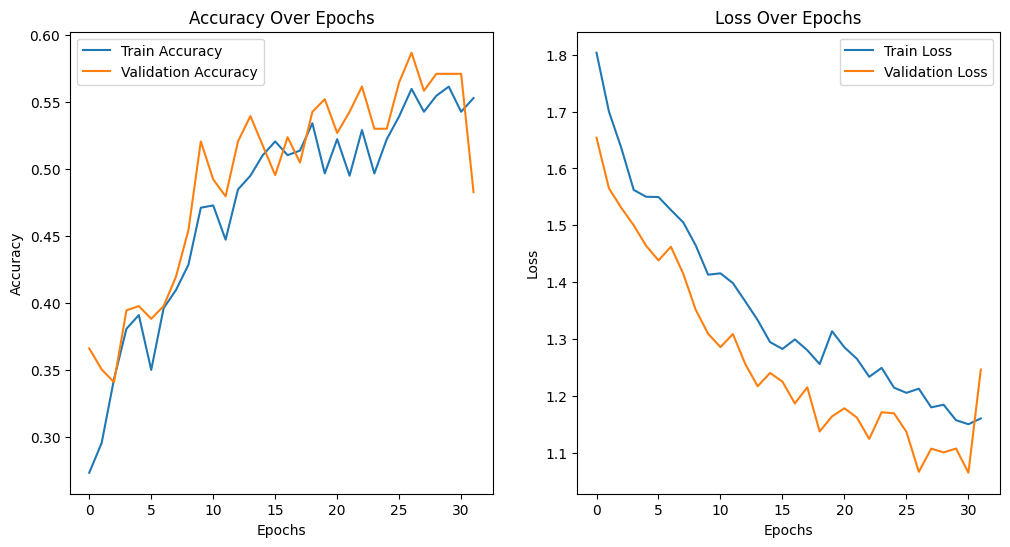

In [61]:
# Step 6: Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [54]:
# Save the model
model.save("ViT.h5")
print("Model saved.")

Model saved.
